In [1]:
import sys
print(sys.version) # 3.6.8

3.6.8 (default, Dec 24 2018, 19:24:27) 
[GCC 5.4.0 20160609]


In [2]:
import tensorflow as tf

tf.enable_eager_execution()

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm

import numpy as np
import pandas as pd

import h5py

import pickle
import cv2
import os

import PIL
import time
import pathlib

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, r2_score

from pandas.plotting import scatter_matrix

from scipy.stats import gaussian_kde

from math import sqrt

from itertools import combinations, combinations_with_replacement

In [284]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

df = pd.read_csv('/data/fp_ica.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50540 entries, 0 to 50539
Data columns (total 29 columns):
Unnamed: 0           50540 non-null int64
ID                   50540 non-null object
true_year            50540 non-null float64
prediction           50540 non-null float64
row                  50540 non-null int64
factor0              50540 non-null float64
factor1              50540 non-null float64
factor2              50540 non-null float64
factor3              50540 non-null float64
factor4              50540 non-null float64
factor5              50540 non-null float64
factor6              50540 non-null float64
year                 50540 non-null int64
N_Housings           50540 non-null int64
N_Units              50540 non-null int64
Max_Floors           50540 non-null int64
Min_Floors           50540 non-null int64
sgg                  50540 non-null int64
sido_sgg_name        50540 non-null object
sido                 50540 non-null int64
sido_name            50540 non-

In [5]:
BATCH_SIZE = 8

def _parse_predict_function(example_proto):
    # Create a description of the features.  
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        'floorplan': tf.FixedLenFeature([28, 28, 6], tf.float32, 
                                        default_value=tf.zeros([28, 28, 6], tf.float32)),
        
        'plan_id': tf.FixedLenFeature([], tf.string, default_value=''),
        'norm_year': tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        'sido': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'norm_area': tf.FixedLenFeature([], tf.float32, default_value=0.0),
        'is_area_85': tf.FixedLenFeature([], tf.int64, default_value=0),
        'is_core': tf.FixedLenFeature([], tf.int64, default_value=0),
        'num_rooms': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'num_baths': tf.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)
    
    return parsed_example['floorplan'], parsed_example['plan_id'], parsed_example['norm_year']

def create_predict_dataset(filepaths):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepaths, compression_type="GZIP")
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_predict_function, num_parallel_calls=8)

    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

In [6]:
predict_dataset =  create_predict_dataset(
    ["/data/fp_train.tfrecord",
     "/data/fp_test.tfrecord"])
iter = predict_dataset.make_one_shot_iterator()

fps = []
for batch in iter:
    fps.extend(batch[0].numpy())

len(fps), fps[0][:,:,0].shape

W1216 10:44:37.233496 140319824795392 deprecation.py:323] From <ipython-input-6-ab9e2d84ac5f>:4: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


(50540, (28, 28))

[[ 0.    0.    0.    1.  ]
 [-1.   -0.67 -1.    0.  ]
 [ 0.   -0.75 -1.    0.  ]
 [-1.   -0.74  0.    0.  ]
 [-0.17 -0.13 -1.    0.  ]
 [-1.   -0.19 -0.24  0.  ]]
(28, 28, 6)
(50540, 28, 28, 4)
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]


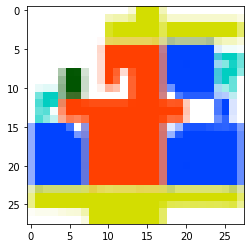

In [7]:
# adjusted for different luminance
channel_to_rgba = np.array(
    [[0., 0., 0., 1.], # unit mask to alpha
     [0., 0.33, 0., 0.], # entrance to green L30
     [1., 0.25, 0., 0.], # LDK to red L57
     [0., 0.26, 1., 0.], # bedroom to blue L40
     [0.83, 0.87, 0., 0.], # balcony to yellow L85
     [0., 0.81, 0.76, 0.]]) # bathroom to cyan L75

# make colors subtractive
channel_to_rgba[1:6, 0:3] -= 1

print(channel_to_rgba)
print(fps[0].shape)

# put it on transparent white
fps_rgba = np.array([1.,1.,1.,0.])+(np.array(fps) @ channel_to_rgba)
print(fps_rgba.shape)

np.set_printoptions(suppress=True)
print(np.amin(fps_rgba, axis=(1,2,3)))
print(np.amax(fps_rgba, axis=(1,2,3)))
fps_rgba = np.clip(fps_rgba, 0, 1)

fig = plt.figure()
ax = plt.imshow(fps_rgba[5])

In [217]:
clusters = [
    {
        "x": {"name": "year", "min": 1984, "max": 1992},
        "y": {"name": "factor0", "min": -4.5, "max": -2.0},
    },
    {
        "x": {"name": "year", "min": 2002, "max": 2010},
        "y": {"name": "factor3", "min": -2.5, "max": -1.0},
    },
    {
        "x": {"name": "year", "min": 2010, "max": 2017},
        "y": {"name": "factor6", "min": 1.0, "max": 4.25},
    },
]

filters = [
    {"label": "$60\mathrm{m^2}$", "query": "57.0<Area<62.0"},
    {"label": "$85\mathrm{m^2}$", "query": "82.0<Area<87.0"},
]


n_bins = (20, 10)

In [218]:
from typing import Dict, Tuple, Any


def fpmap2d(
    fps: np.ndarray,
    df: pd.DataFrame,
    region: Dict[str, Dict[str, Any]],
    filter_query: Dict[str, str],
    n_bins: Tuple[int, int],
) -> np.ndarray:

    border = 2
    interval = 28 + border * 2

    # bins

    df_bins = df[["row"]].copy()

    n_bins_dict = {
        axis: min(
            n_bins[i],
            len(
                df.loc[
                    df[region[axis]["name"]].between(
                        region[axis]["min"], region[axis]["max"]
                    )
                ][region[axis]["name"]].unique()
            ),
        )
        for i, axis in enumerate("xy")
    }

    for i, axis in enumerate("xy"):
        bins = np.linspace(
            region[axis]["min"], region[axis]["max"], num=n_bins_dict[axis] + 1
        )
        df_bins[axis] = pd.cut(
            df[region[axis]["name"]],
            bins,
            right=True,
            include_lowest=True,
            labels=False,
        )

    # boolean filter

    df_bins["filter"] = df.eval(filter_query)

    # create 2d map

    fp_map = np.zeros(
        (n_bins_dict["y"] * interval, n_bins_dict["x"] * interval, fps.shape[-1],)
    )  # rc coord

    for x in range(n_bins_dict["x"]):
        for y in range(n_bins_dict["y"]):

            df_sample = df_bins.query("x == @x and y == @y and filter == True")
            # if x==3 and y ==2:
            #     print(df_sample)
            r, c = n_bins_dict["y"] - 1 - y, x

            if len(df_sample):
                row = df_sample.sample(1, random_state=1106).row.iat[0]
                fp_map[
                    r * interval + border : (r + 1) * interval - border,
                    c * interval + border : (c + 1) * interval - border,
                    :,
                ] = fps[row]

    return fp_map

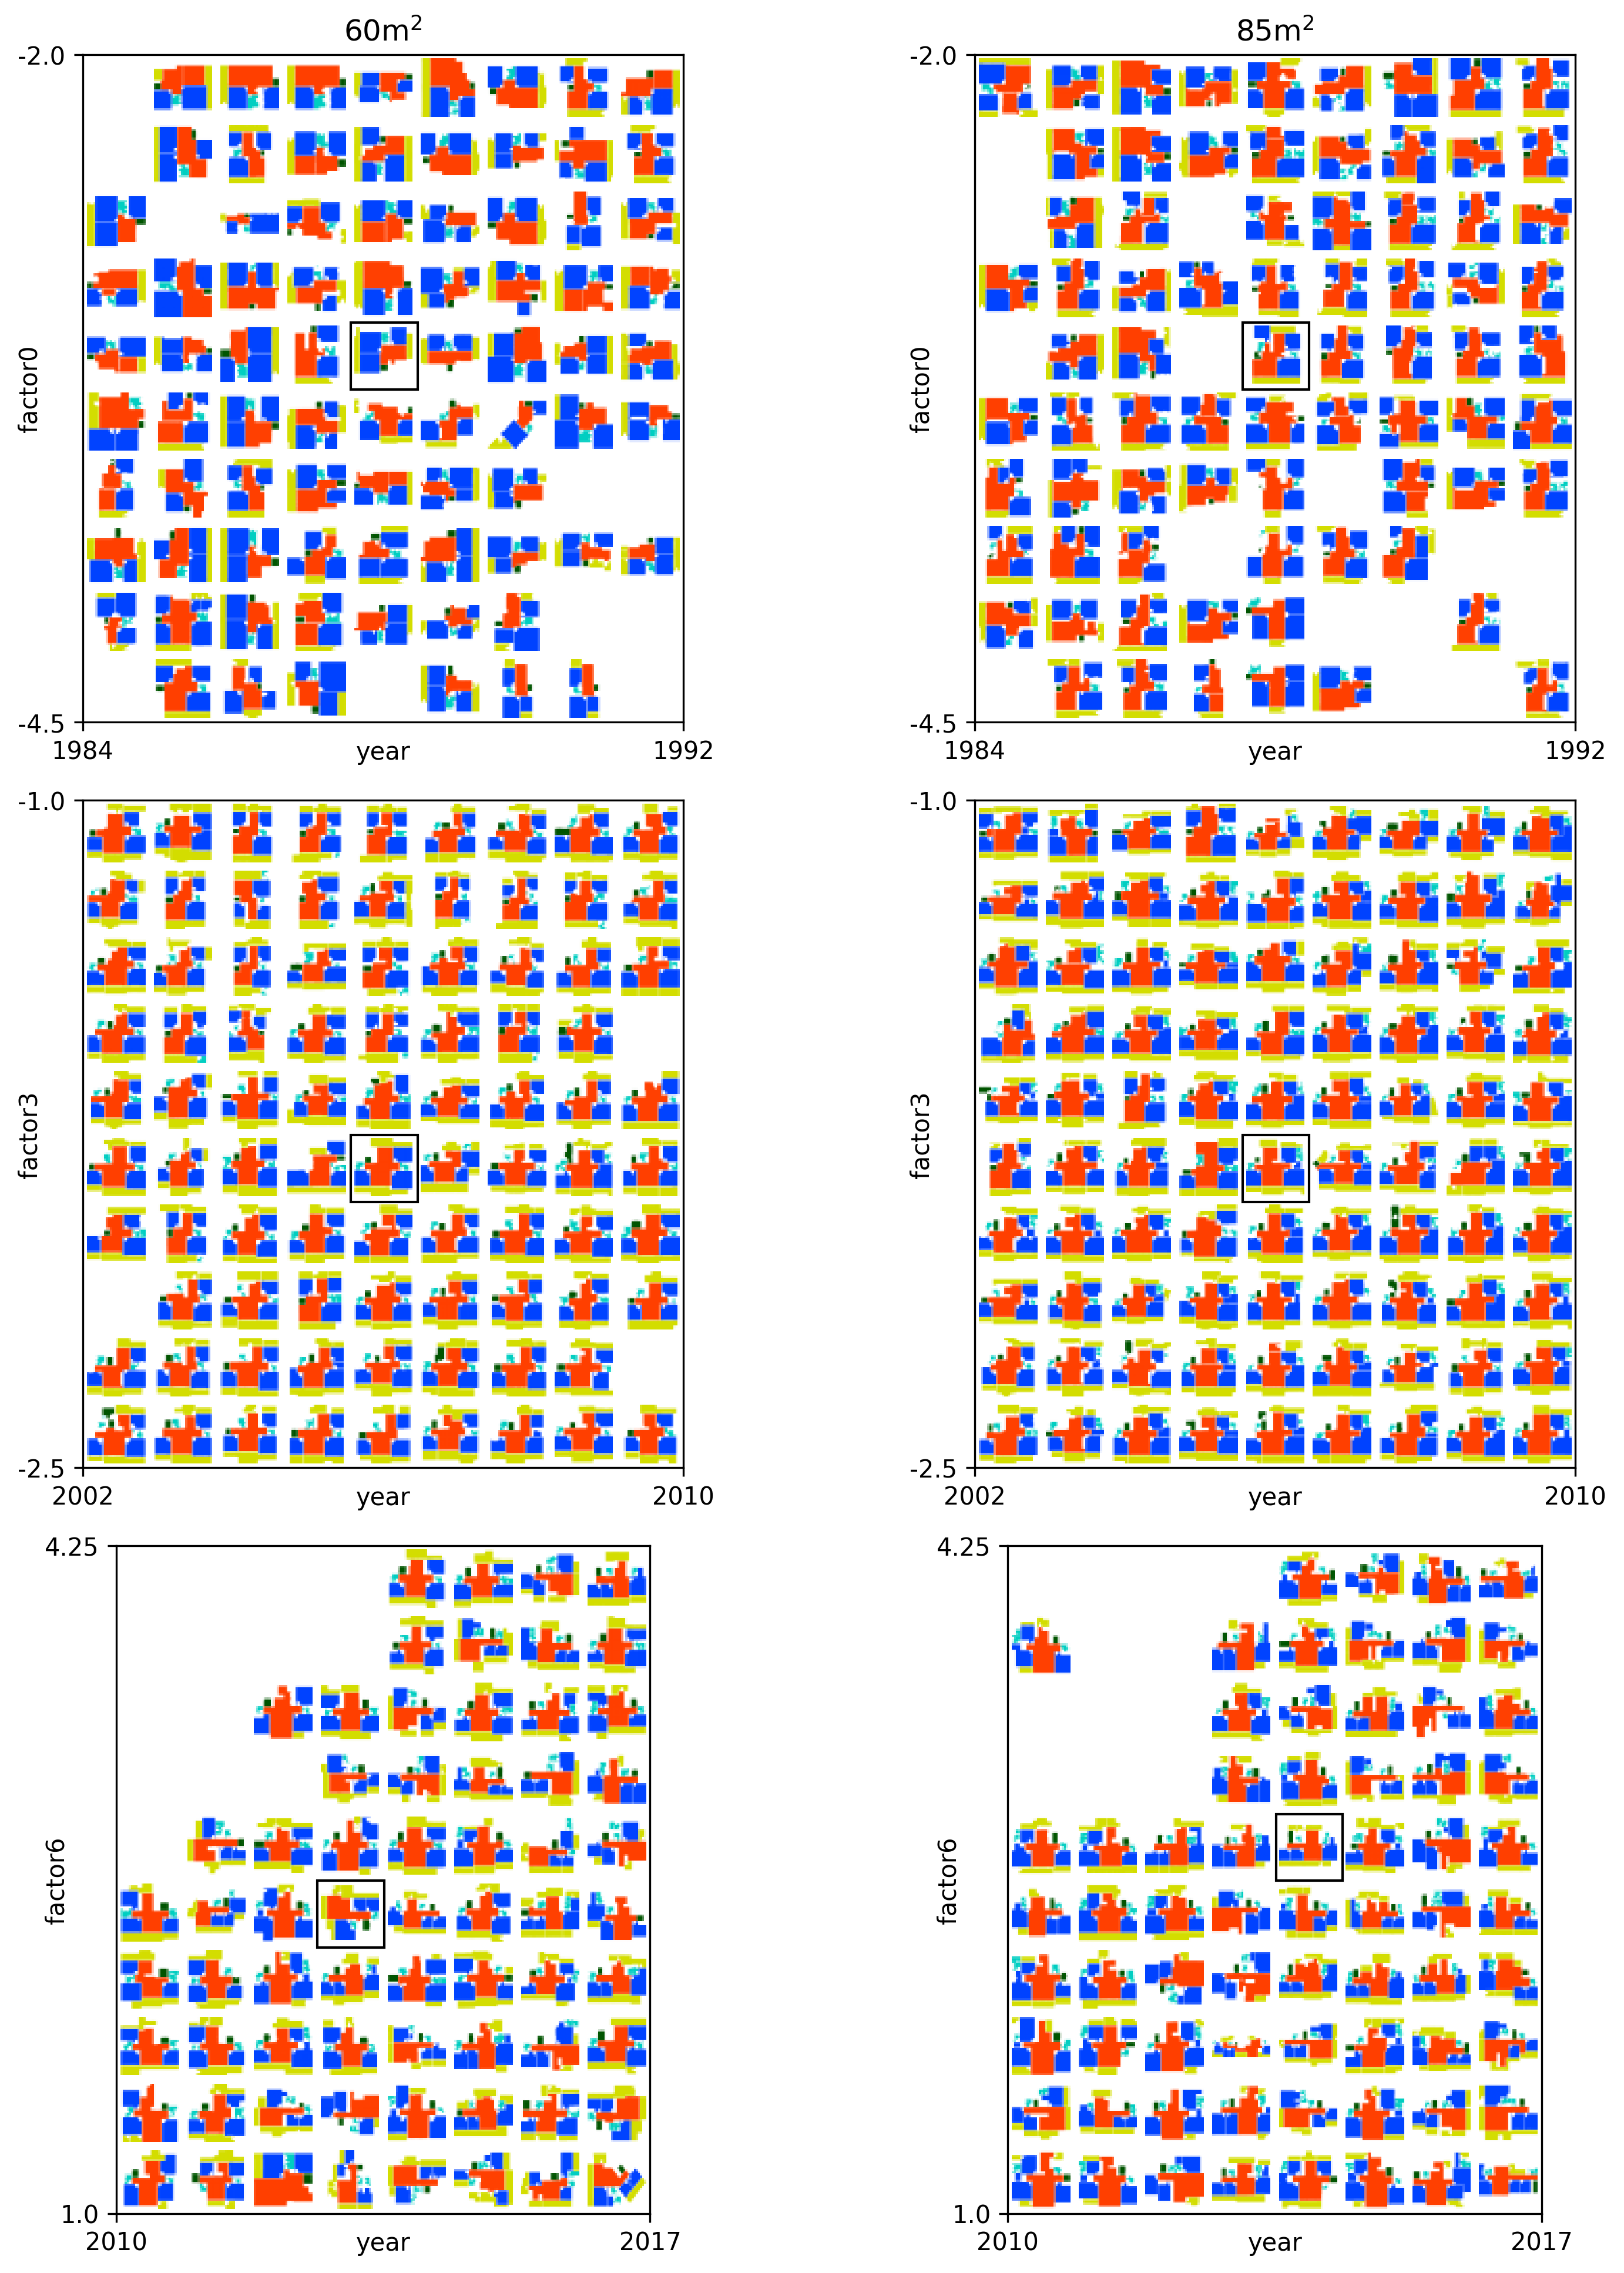

In [278]:
from matplotlib.transforms import blended_transform_factory
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(
    nrows=len(clusters), ncols=len(filters), figsize=(11, 13), dpi=300
)
for i, clust in enumerate(clusters):
    for j, filt in enumerate(filters):
        axes[i, j].imshow(fpmap2d(fps_rgba, df, clust, filt["query"], n_bins),)

        axes[i, j].set_xlabel(clust["x"]["name"], labelpad=-10)
        axes[i, j].set_ylabel(clust["y"]["name"], labelpad=-10)

        axes[i, j].set_xticks(axes[i, j].get_xlim())
        axes[i, j].set_yticks(axes[i, j].get_ylim())
        axes[i, j].set_xticklabels([clust["x"]["min"], clust["x"]["max"]])
        axes[i, j].set_yticklabels([clust["y"]["min"], clust["y"]["max"]])


for j, filt in enumerate(filters):
    axes[0, j].set_title(filt["label"])

picks = [
    [(4, 4), (4, 4),],
    [(5, 4), (5, 4),],
    [(5, 3), (4, 4),],
]

for i, clust in enumerate(clusters):
    for j, filt in enumerate(filters):
        r, c = picks[i][j]
        rect = Rectangle(
            (c * 32, r * 32),  # xy??
            32,
            32,
            linewidth=1,
            edgecolor="k",
            facecolor="None",
            alpha=1,
        )
        axes[i, j].add_patch(rect)

plt.tight_layout()

fig.savefig("cluster_floorplans.pdf", bbox_inches="tight", pad_inches=0)
fig.savefig("cluster_floorplans.png", bbox_inches="tight", pad_inches=0)

7781_68B
272_104
22176_78
18951_104
103531_83C
104423_110


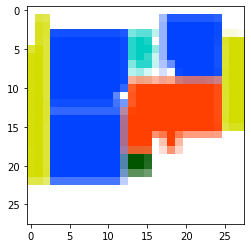

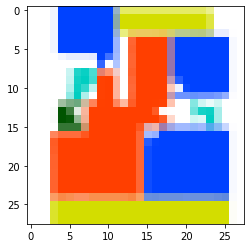

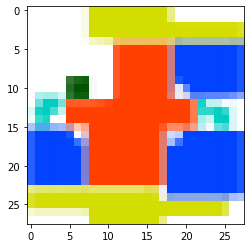

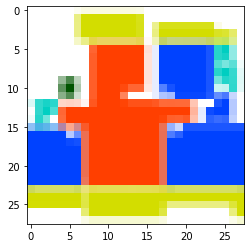

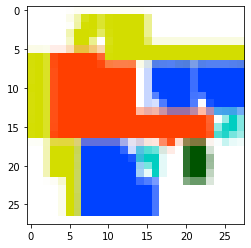

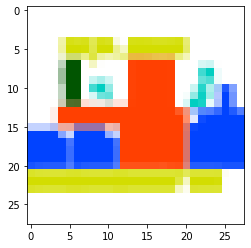

In [288]:
picks = [
    [(4, 4), (4, 4),],
    [(5, 4), (5, 4),],
    [(5, 3), (4, 4),],
]


def fppick(
    fps: np.ndarray,
    df: pd.DataFrame,
    region: Dict[str, Dict[str, Any]],
    filter_query: Dict[str, str],
    n_bins: Tuple[int, int],
    r: int,
    c: int,
) -> Tuple[str, np.ndarray]:

    border = 2
    interval = 28 + border * 2

    # bins

    df_bins = df[["row", "ID"]].copy()

    n_bins_dict = {
        axis: min(
            n_bins[i],
            len(
                df.loc[
                    df[region[axis]["name"]].between(
                        region[axis]["min"], region[axis]["max"]
                    )
                ][region[axis]["name"]].unique()
            ),
        )
        for i, axis in enumerate("xy")
    }

    for i, axis in enumerate("xy"):
        bins = np.linspace(
            region[axis]["min"], region[axis]["max"], num=n_bins_dict[axis] + 1
        )
        df_bins[axis] = pd.cut(
            df[region[axis]["name"]],
            bins,
            right=True,
            include_lowest=True,
            labels=False,
        )

    # boolean filter

    df_bins["filter"] = df.eval(filter_query)

    # create 2d map

    fp_map = np.zeros(
        (n_bins_dict["y"] * interval, n_bins_dict["x"] * interval, fps.shape[-1],)
    )  # rc coord

    #     r, c = n_bins_dict["y"] - 1 - y, x
    x, y = c, n_bins_dict["y"] - 1 - r
    df_sample = df_bins.query("x == @x and y == @y and filter == True")
    sample = df_sample.sample(1, random_state=1106)
    fp_ID = sample.ID.iat[0]
    row = sample.row.iat[0]

    return fp_ID, fps[row]


for i, clust in enumerate(clusters):
    for j, filt in enumerate(filters):
        ID, fp = fppick(fps_rgba, df, clust, filt["query"], n_bins, *picks[i][j])
        print(ID)
        plt.figure()
        plt.imshow(fp)